# Day 14

# part 1

- robots move in straight lines from some position with some velocity
- x = 0 is left and y = 0 is at the top
- +x is right and +y is down
- robots don't bump into eachother
- when a robot hits a wall they wrap around to the otherside
- simulate for 100 seconds
- find the product of the number of robots in each quadrant (ignoring the centre lines)
- the puzzle grid is 101 wide by 103 tall

In [19]:
from copy import deepcopy
from dataclasses import dataclass
import logging

from matplotlib import pyplot as plt
from tqdm import tqdm

from advent_of_code_utils.advent_of_code_utils import (
    parse_from_file, ParseConfig as PC, Point2 as P, plot_grid, create_gif,
    embed_image
)

log = logging.getLogger('day 14')
logging.basicConfig(level=logging.INFO)

In [15]:
@dataclass
class Robot:
    p: P
    v: P

    def move(self, gridsize: P) -> None:
        """moves the robot one step"""
        self.p = P(
            (self.p.x + self.v.x) % gridsize.x,
            (self.p.y + self.v.y) % gridsize.y,
        )

def parse_robot(robot_str: str) -> Robot:
    """creates a robot from the puzzle input"""
    p_str, v_str = robot_str.split(' ')
    p = P(*(int(val) for val in p_str[2:].split(',')))
    v = P(*(int(val) for val in v_str[2:].split(',')))
    return Robot(p, v)

parser = PC('\n', parse_robot)
robots = parse_from_file('day_14.txt', parser)
gridsize = P(101, 103)

INFO:advent_of_code_utils.py:500 items loaded from "day_14.txt"


INFO:advent_of_code_utils.py:12 items loaded from "day_14_example.txt"


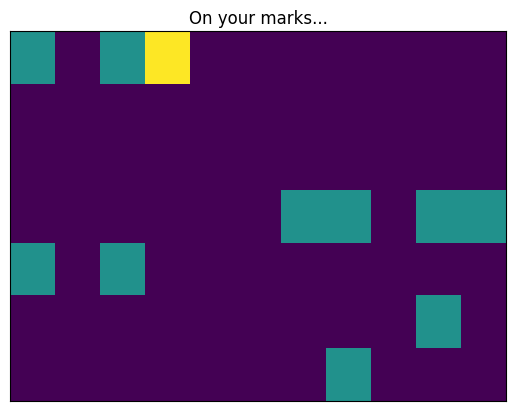

In [16]:
example = parse_from_file('day_14_example.txt', parser)

def plot_robots(robots: list[Robot], ax: plt.Axes, size=gridsize) -> None:
    """displays all the robots on a grid"""
    grid = [[0]*size.x for _ in range(size.y)]
    for robot in robots:
        grid[robot.p.y][robot.p.x] += 1
    plot_grid(grid, ax)

fig, ax = plt.subplots()
ax.set_title('On your marks...')
plot_robots(example, ax, P(11, 7))

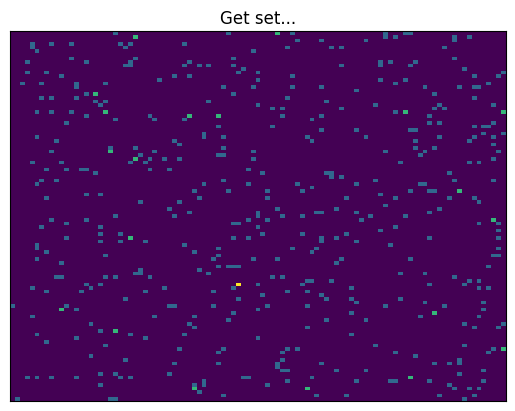

In [17]:
# cool that's the right way up - just wanted to be sure!
fig, ax = plt.subplots()
ax.set_title('Get set...')
plot_robots(robots, ax)

In [21]:
frames = [deepcopy(robots)]
for _ in tqdm(range(100)):
    for robot in robots:
        robot.move(gridsize)
    frames.append(deepcopy(robots))

100%|██████████| 100/100 [00:00<00:00, 107.82it/s]


INFO:advent_of_code_utils.py:Creating 101 frame images using "plot_robots()"
generating frames: 100%|██████████| 101/101 [00:03<00:00, 30.88it/s]
INFO:advent_of_code_utils.py:101 images saved to "img_temp"
INFO:advent_of_code_utils.py:Creating "day_14.gif" with frame duration 200ms
INFO:advent_of_code_utils.py:"day_14.gif" saved!
INFO:advent_of_code_utils.py:"img_temp" cleaned up
INFO:advent_of_code_utils.py:Embedding "day_14.gif"


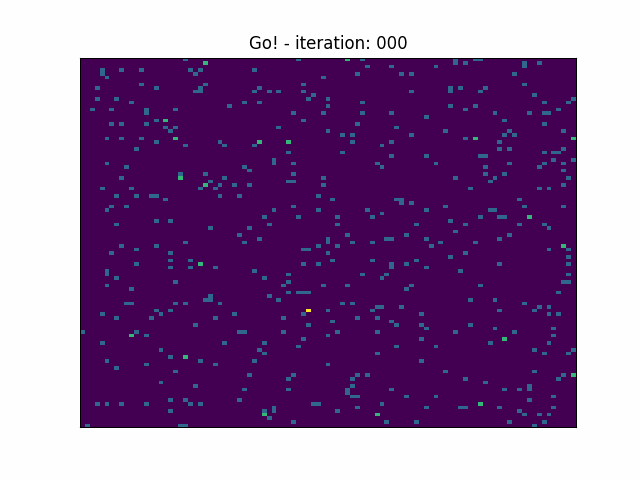

In [32]:
gifpath = create_gif(frames, plot_robots, 'day_14', append_iteration=True, title='Go!', frame_duration_ms=200)
embed_image(gifpath)